### TP 3 : 

###### Group : Alexandre BOISTARD, William ROCHE, Ethan TRENTIN

In [90]:
import numpy 
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import powerlaw
import statsmodels
from statsmodels import api
import tqdm   
import Hawkes as hwk

First, let's implement a function that simulates one path of a Hawkes process with a generic decreasing kernel using the thinning algorithm. 

For both the thinning and the branching algorithm, we will require the definition of a generic decreasing kernel. We will implement an exponential kernel in the following function.

In [91]:
def exponential_kernel(t, alpha, beta):
    return alpha*numpy.exp(-beta*numpy.where(t>=0, t, numpy.inf)) # We want to choose t when t >= 0 and numpy.inf when t < 0 as we need to model a indicatrice function.

In [92]:
def thinning_Hawkes_process(T, kernel_func, alpha = 0.6, beta = 0.8, lambda_0=1.2):
    t = 0
    lambda_star = lambda_0
    events = []
    while t < T:
        U = numpy.random.uniform(0,1)
        t -= numpy.log(U)/lambda_star
        if t >= T:
            return events 
        D = numpy.random.uniform(0,1)
        lambda_t = lambda_0 + sum(kernel_func(t-t_i, alpha, beta) for t_i in events[:-1]) 
        if D <= lambda_t/lambda_star:
            events.append(t)
            lambda_star = lambda_t+alpha
        else:
            lambda_star = lambda_t
    return events

Next, we are going to write a function that simulates one path of a Hawkes process with a generic decreasing kernel (again we will use the exponential kernel) using the branching algorithm. 

To do so, we need first to implement the simulation of a non-homogeneous poisson process. We will use the code from lab 2, by updating it. 

In [93]:
def simulate_nonhomogeneous_poisson(start, end, mu, mu_max=1):
    
    events = []
    t = start
    
    while t < end:
        t += numpy.random.exponential(1 / mu_max)
        if t >= end:
            break
        
        if numpy.random.uniform(0, 1) < mu(t) / mu_max:
            events.append(t)
    
    return events

In [94]:
def branching_Hawkes_process(kernel_func, T, alpha=0.6, beta=0.8, intensity=1.2):
    t = 0
    poissons = []
    while t < T:
        t += numpy.random.exponential(1/intensity)
        if t<T: 
            poissons.append(t)
    new_pt = True 
    Ti1 = poissons.copy()
    while new_pt:
        new_pt = False
        Ti2 = []
        for pt in Ti1:
            Ti3 = simulate_nonhomogeneous_poisson(pt,T,lambda t:kernel_func(t-pt, alpha, beta),1)
            if Ti3:
                new_pt = True
                Ti2.extend(Ti3)
        Ti1 = Ti2.copy()
        poissons.extend(Ti2)
    return numpy.sort(poissons)

Now, to visualize the results of our algorithm, we are going to plot the Hawkes processes resulting from both the thinning and the branching algorithms. 

In [95]:
def plot_Hawkes(events, T, algorithm, kernel_func, alpha = 0.6, beta = 0.8, lambda_0=1.2):
    interval = numpy.linspace(0,T,1000)
    values = numpy.zeros(1000)+lambda_0
    for event in events:
        values += alpha*numpy.exp(-beta*numpy.where(interval-event>0, interval-event, numpy.inf))
    plt.figure(figsize=(10,6))
    plt.scatter(events, numpy.ones(len(events)), color = 'red', label='Events')
    plt.plot(interval, values, label='Intensity')
    plt.title(f"Simulation of one path of a Hawkes process with the {algorithm} algorithm and the {kernel_func} kernel")
    plt.xlabel('Time')
    plt.ylabel('Intensity')
    plt.legend()
    plt.show()        

In [96]:
test_Hawkes_thinning = thinning_Hawkes_process(10, exponential_kernel)
test_Hawkes_thinning

[1.494061082064019,
 1.6015375274749806,
 2.0270293422244503,
 4.914655687891504,
 6.05604233757647,
 6.280018949194091,
 7.118747068930518,
 8.758995670741086,
 8.75901379034025,
 9.728361717617535]

In [97]:
test_Hawkes_branching = branching_Hawkes_process(exponential_kernel, 10)
test_Hawkes_branching

array([2.17882807, 2.29891728, 2.34814958, 2.37855083, 2.45987526,
       2.83613533, 3.18359686, 3.47176784, 3.48009494, 3.55285228,
       3.56283542, 3.7881196 , 3.93267011, 3.94829312, 4.41521361,
       4.46748289, 4.69359623, 4.72977206, 4.87053734, 4.91245586,
       4.9742377 , 5.04848315, 5.30660021, 5.46885612, 5.5516023 ,
       5.79930293, 6.16424099, 6.44211582, 6.5086032 , 6.62641079,
       6.6844079 , 6.8134617 , 7.13996221, 7.39634002, 7.66507122,
       7.7428949 , 7.766602  , 7.91975756, 7.95079321, 7.96980775,
       8.05677749, 8.45821712, 8.56494758, 8.78335097, 8.81514357,
       8.85229417, 8.85573986, 9.06163469, 9.07274768, 9.14116387,
       9.20158189, 9.23904407, 9.2556522 , 9.37195921, 9.64295654])

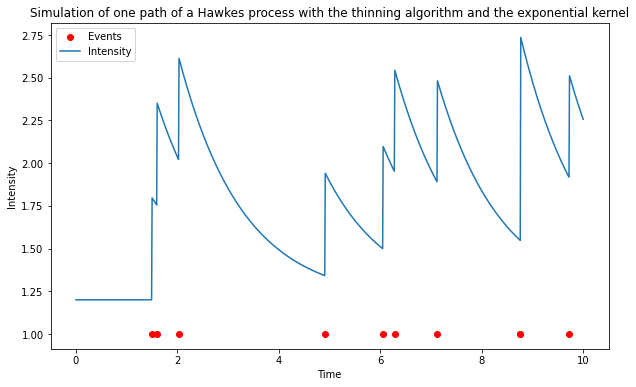

In [98]:
plot_Hawkes(test_Hawkes_thinning, 10, "thinning", "exponential")

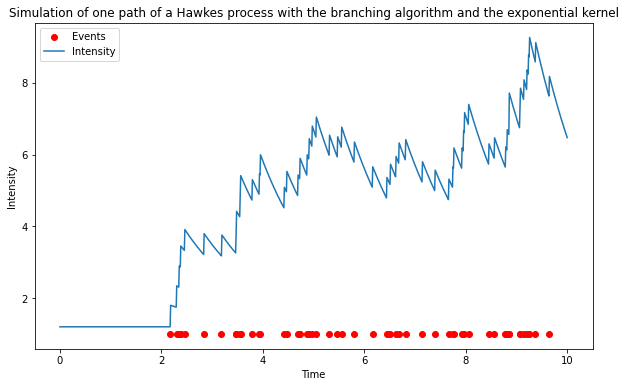

In [99]:
plot_Hawkes(test_Hawkes_branching, 10, "branching", "exponential")

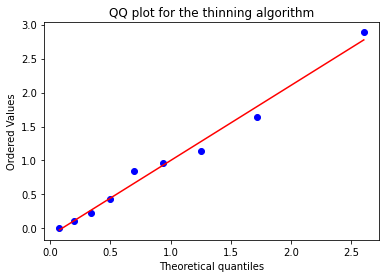

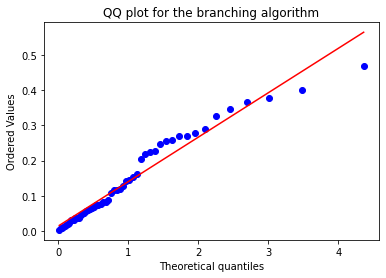

In [100]:
def qq_plot_hawkes(events, title="QQ plot for the Hawkes process"):
    inter_event_times = numpy.diff(events) 
    scipy.stats.probplot(inter_event_times, dist="expon", plot=plt)
    plt.title(title)
    plt.show()

qq_plot_hawkes(test_Hawkes_thinning, title="QQ plot for the thinning algorithm")
qq_plot_hawkes(test_Hawkes_branching, title="QQ plot for the branching algorithm")

Question 1 : **Properties of Hawkes MLE estimates**. Check that MLE estimators computed with the Hawkes library on samples simulated by our simulators exhibit expected statistical properties. 

First, let's define a function to simulate multiple paths of a Hawkes process, with the name of the algorithm as a variableso that the function adapts to both thinning and branching algorithm. 

In [103]:
def mulitple_hawkes_paths(num_paths, T, kernel_func, algorithm, alpha = 0.6, beta = 0.8, lambda_0=1.2):
    paths = []
    for _ in range(num_paths):
        if algorithm == "thinning":
            event = thinning_Hawkes_process(T, kernel_func, alpha, beta, lambda_0)
        elif algorithm == "branching":
            event = branching_Hawkes_process(kernel_func, T, alpha, beta, lambda_0)
        paths.append(event)
    return paths

Now, we define a function that computes the estimation of the parameters using the Maximum-likelihood estimator $\hat{\theta}_T=(\hat{\lambda_0}, \hat{\alpha_j},\hat{\beta_j})$

In [ ]:
def MLE_parameters_estimations(paths, kernel_func):
    estimations = []
    for event in paths:
        model = hwk.HawkesProcess(kernel_func)
        model.fit(event)
        estimations.append(model.estimated_params)
    return estimations

In [111]:
paths = mulitple_hawkes_paths(1000, 10, exponential_kernel, "thinning")
estimations = MLE_parameters_estimations(paths, exponential_kernel)
estimations

AttributeError: module 'Hawkes' has no attribute 'Hawkes'